In [1]:
# Configurações para a apresentação de slides com o Jupyter Notebook
# Instalar temas do Jupyter:
# >> pip install jupyterthemes
# Listar temas disponíveis:
# >> jt -l
# Selecionar o tema para a apresentação:
# >> jt -t monokai
# Retornar ao tema original:
# >> jt -r

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    "start_slideshow_at": "selected",
    "transition": "zoom",
    "height": 768,
    "width": 1024,
    "theme": "simple",
    "scroll": True,
})

{'theme': 'simple',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'width': 1024,
 'height': 768,
 'scroll': True}

# EPM Web API (Python) - primeiros passos...

## Operações típicas

1. **Estabelecimento de Conexão** (=sessão) com um **EPM Server** (=servidor de dados)
2. **Criação** das variáveis de interesse
    * definir variáveis de interesse (eventualmente suas propriedades)
    * executar criação no ambiente Python da variável de interesse (contraparte do **EPM Server**)
3. **Leitura** de valores escalares
    * definir variável de interesse
    * executar leitura
4. **Leitura** de valores históricos
    * definir variável de interesse
    * definir período de interesse
    * definir tipo de agregação (=processamento)
    * executar leitura
5. **Leitura** de anotações
    * definir variável de interesse
    * definir período de interesse
    * executar leitura
6. **Escrita** de valores escalares
    * definir variável de interesse
    * definir valor, timestamp e qualidade
    * executar escrita
7. **Escrita** de valores históricos
    * definir variável de interesse
    * definir vetor de valores, timestamps e qualidades
    * executar escrita
8. **Escrita** de anotações *(mais indicado: EPM Dataset Analysis | EPM Processor)*
    * definir variável de interesse
    * definir mensagem e timestamp
    * executar escrita
9. **CRUD** (Create, Read, Update and Delete) de variáveis - não faz parte do escopo deste minicurso
10. **Encerramento da Conexão** (=sessão) com um **EPM Server** (=servidor de dados)

1. **Estabelecimento de Conexão** (=sessão) com um **EPM Server** (=servidor de dados)

In [2]:
# No ambiente Jupyter - fazer gráfico no próprio ambiente usando a MATPLOTLIB
%matplotlib inline

# Importação dos principais módulos utilizados em Análises de Dados de Processo
# Dica:
# Sempre procurar tratar as exceções para facilitar a manutenção dos códigos e a utilização por terceiros!
try:
    import numpy as np
    import datetime
    import pytz
    import matplotlib.pyplot as plt
    # Importação do módulo para conecão com o EPM Server (via EPM Web Server)
    import epmwebapi as epm
    print('Módulos importados com sucesso!')
except ImportError as error:
    print('Erro na importação!')
    print(error.__class__.__name__ + ': ' + error.message)
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Módulos importados com sucesso!


In [3]:
# ATENÇÃO:
# Para uso em produção, é recomendado usar variáveis de ambiente para buscar informações de Usuário/Senha.
# Para este minicurso será utilizado as funções input e getpass
import getpass  # MINHA PRÁTICA - todos import's no início!
user = input('EPM user:')
password = getpass.getpass("EPM password:")
epm_auth = 'http://epmtr.elipse.com.br:44333' # 'http://localhost:44333'
epm_web  = 'http://epmtr.elipse.com.br:44332' # 'http://localhost:44332'

# Criação de uma conexão (sessão) informando os endereços do EPM Webserver(Authentication Port e WEB API Port), usuário e senha.
try:
    epmConn = epm.EpmConnection(epm_auth, epm_web, user, password)
    # A forma mais recomendada (fácil) para usar o comando print é com fstring
    print(f'Conexão com {epm_web} criada com sucesso para o usuário {user}.')
except:
    print(f'Falha no estabelecimento da conexão com {epm_web} para o usuário {user}.')

EPM user:mauricio
EPM password:········
Conexão com http://epmtr.elipse.com.br:44332 criada com sucesso para o usuário mauricio.


2. **Criação** das variáveis de interesse

In [4]:
# DICA:
# Definir uma lista com as variáveis de interesse para facilitar seu uso/reuso
bvList = ['LIC101', 'FIC101']
bvDic = epmConn.getDataObjects(bvList)
bv_LIC101 = bvDic[bvList[0]]
bv_FIC101 = bvDic[bvList[1]]
print('Nível do tanque: {}'.format(bv_LIC101)) # outra forma de usar o comando print é com o método format
print('Válvula do tanque: {}'.format(bv_FIC101))

Nível do tanque: <epmwebapi.basicvariable.BasicVariable object at 0x000002053F38CA20>
Válvula do tanque: <epmwebapi.basicvariable.BasicVariable object at 0x000002053FAFDB00>


### Dica

###### É possível usar filtros para pesquisar as variáveis de interesse e criá-las no ambiente Python.

###### *exemplo*: é possível que se busque por todas as variáveis que tenham °C como unidade de medida.

###### Exemplos de uso de filtros podem ser vistos no GitHub da Elipse Software:
[Elipse Software/epmwebapi/exemplos/Quickstart.ipynb](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/blob/master/exemplos/Quickstart.ipynb)

#### Usando as funções *dir* para ver métodos-propriedades e filtro com regex sobre strings para eliminar os métodos-propriedades "privados"

In [5]:
import re
# DICA: https://regex101.com/
regex = re.compile(r'[^\b_]') # <=> Não iniciar palavra com _
all_meth_props = dir(bv_LIC101)
meth_props = list(filter(regex.match, all_meth_props))
print(*meth_props, sep=" | ")

clamping | copy | deadBandFilter | deadBandUnit | delete | deleteAnnotations | description | domain | enumProperties | eu | highLimit | historyDelete | historyReadAggregate | historyReadRaw | historyUpdate | inputHighLimit | inputLowLimit | interface | ioTagAddress | isCompressing | isRecording | lowLimit | name | path | processingEnabled | read | readAnnotations | readAttributes | realTimeEnabled | recordedValue | save | scaleEnable | storageSet | storeMillisecondsEnabled | tagType | write | writeAnnotation


#### Por padrão, *name* é a única propriedade lida do EPM Server para criação da *Basic Variable* no ambiente Python.

In [6]:
# Por padrão, "name" é a única propriedade necessária para instanciar uma Basic Variable
print(f'Variável: {bv_LIC101.name}')
print(f'Descrição: {bv_LIC101.description }')
print(f'Unidade de Medida (= E.U.): {bv_LIC101.eu}')

Variável: LIC101
Descrição: None
Unidade de Medida (= E.U.): None


#### Quando for necessário saber o valor destas propriedades, é necessário: (i) criar a variávle no ambiente Python solicitando que estes valores sejam lidos na criação da mesma; (ii) proceder com a leitura destas propriedades sob demanda após a criação da mesma.

In [7]:
# Exemplo de busca das propriedades da variável bv_LIC101 (previamente criada)
bv_LIC101.readAttributes()
print(f'Variável: {bv_LIC101.name}')
print(f'Descrição: {bv_LIC101.description }')
print(f'Unidade de Medida (= E.U.): {bv_LIC101.eu}')

Variável: LIC101
Descrição: Nível do tanque
Unidade de Medida (= E.U.): m


3. **Leitura** de valores escalares

#### Lê o último valor proveniente da via de tempo real do EPM Server: (i) via *Interface de Comunicação*; (ii) via escrita com o método *write*.

#### Valores inseridos na base de dados através: (i) restauração de bkp; (ii) uso do EPM Tag Port (); (iii)  função historyUpdate;  só são acessados através de consultas históricas, como historyRead e historyReadAggregate.

In [8]:
# Trazendo par ao ambiebte Python uma variável que tem dados provenientes da via de tempo real (rand01)
rand01 = epmConn.getDataObjects(['rand01'])['rand01']
last_value = rand01.read()
print(f'Último valor recebido pela via de tempo real: {last_value.value}')
print(f'Último timestamp associado ao valor: {last_value.timestamp}')
print(f'Última qualidade associada ao valor: {last_value.statusCode} - 0 corresponde à "Good" no Padrão OPC UA')
# Notas:
# * No padrão OPC DA Classic 192 corresponde à qualidade "Good"
# * O Timestamp é informado SEMPRE em UTC

Último valor recebido pela via de tempo real: 85.01898193359375
Último timestamp associado ao valor: 2020-08-13 16:30:50.677000+00:00
Última qualidade associada ao valor: 0 - 0 corresponde à "Good" no Padrão OPC UA


4. **Leitura** de valores históricos

##### Valores brutos (raw) - como foram armazenados
##### Agregação - padrão OPC UA


#### Consulta dos valores "brutos" (= raw data)

(1.6148503, datetime.datetime(2014, 3, 4, 2, 0, tzinfo=datetime.timezone.utc), 0)


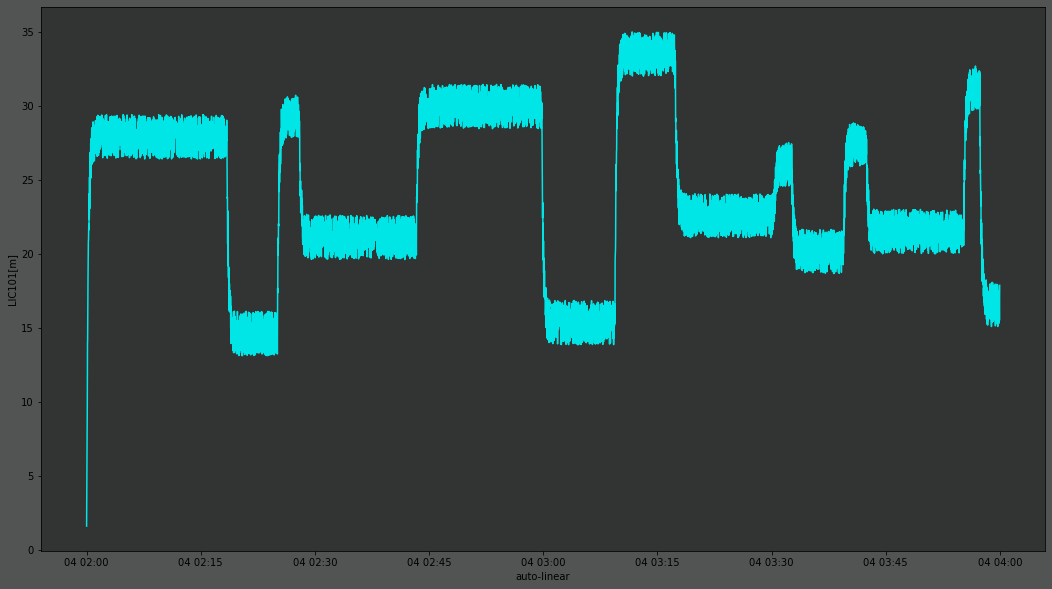

In [9]:
# Consulta dos valores "brutos" (= raw data)
# Valores "devem" ser informados em conforemidade com o Timezone ou em UTC (Coordinated Universal Time)
ini_date = datetime.datetime(2014, 3, 4, 2, tzinfo=pytz.utc)
end_date = datetime.datetime(2014, 3, 4, 4, tzinfo=pytz.utc)
query_period = epm.QueryPeriod(ini_date, end_date)
data = bv_LIC101.historyReadRaw(query_period)
#plt.plot(data['Value'], color='#00e6e6') # plot apenas dos dados
plt.plot(data['Timestamp'], data['Value'], color='#00e6e6') # plot timestamp e dados
plt.xlabel("auto-linear")
plt.ylabel(bv_LIC101.name + '[' + bv_LIC101.eu + ']')

# Notas extras:
# Redimensionando e colorindo a figura posteriormente á sua criação
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')
#fig.savefig(bv_LIC101.name + '.png', dpi=100) # salvar imagem em arquivo

# ATENÇÃO!
# Os Timestamps retornados estão sempre em UTC!
print(data[0])

#### Regras de ouro quando se trabalha com Timestamps

* Sempre usar objetos datetime "offset-aware" (delta do local em relação ao UTC).
* Sempre armazenar datetime em UTC e fazer a conversão do fuso horário apenas ao interagir com usuários.
* Sempre usar a norma internacional ISO 8601 como entrada/saída para repersentações de data-hora.

##### Exemplos norma ISO 8601

* Data: 2019-07-16
* Data e horas separados, em UTC: 2019-07-16 21:02Z
* Data e horas combinadas, em UTC: 2019-07-16T21:02Z
* Data com número da semana: 2019-W29-2
* Data ordinal: 2019-197

In [10]:
# Nota:
# UTC’ is Coordinated Universal Time. It is a successor to, but distinct from, Greenwich Mean Time (GMT) and the various definitions of Universal Time. UTC is now the worldwide standard for regulating clocks and time measurement.
# All other timezones are defined relative to UTC, and include offsets like UTC+0800 - hours to add or
# subtract from UTC to derive the local time. No daylight saving time occurs in UTC, making it a useful
# timezone to perform date arithmetic without worrying about the confusion and ambiguities caused by
# daylight saving time transitions, your country changing its timezone, or mobile computers that roam
# through multiple timezones.
#
# ref.: http://pytz.sourceforge.net/
#
# Verificar os timezones que iniciam por 'America/S'  -> para mostrar Sao_Paulo
print(list(filter(lambda s: s.find('America/S')+1, pytz.common_timezones)))
print(50 * '#')
# ATENÇÃO!
# Wrong value returned from offset for timezones in Brazil
# https://github.com/sdispater/pendulum/issues/319
#
tz_sp = pytz.timezone('America/Sao_Paulo')
ini_date1 = datetime.datetime(2014, 3, 3, 23, tzinfo=tz_sp)
end_date1 = datetime.datetime(2014, 3, 4, 1, tzinfo=tz_sp)
query_period1 = epm.QueryPeriod(ini_date1,end_date1)
data1 = bv_LIC101.historyReadRaw(query_period1)

# Para colocar o OFF-SET manualmente, deve-se primeiro identificá-lo (ou informar manualmente)
now_naive = datetime.datetime.now() # Só para ver que existe um método NOW!
now_aware = datetime.datetime.utcnow() # Usado para identificar o OFFSET
localize = pytz.utc.localize(now_aware) # Só para ver que existe um método localize!
now_sp = now_aware.astimezone(tz_sp) # Usado para identificar o OFFSET
tz_offset = now_sp.tzinfo.utcoffset(now_aware).seconds/(3600) - 24 # is_dst=False -> sem horário de verão!
print(f'Data-hora agora simples, sem informações de Timezone: {now_naive}')
print(f'Data-hora agora com informações de Timezone:          {now_aware}')
print(f'Localização UTC - Timezone:                           {localize}')
print(f'Localização São Paulo - Timezone:                     {now_sp}')
print(f'Off set correto (sem horário de verão):               {tz_offset}')
print(50 * '#')
tz_ok = datetime.timezone(datetime.timedelta(hours=tz_offset))
# tz_ok = -3 # São Paulo (Brasília) - Brasil - sem horário de verão!
ini_date2 = datetime.datetime(2014, 3, 3, 23, tzinfo=tz_ok)
end_date2 = datetime.datetime(2014, 3, 4, 1, tzinfo=tz_ok)
query_period2 = epm.QueryPeriod(ini_date2,end_date2)
data_ok = bv_LIC101.historyReadRaw(query_period2)
# Imprimindo resultado final!
print('Timestamp com problemas: {}'.format(data1[0]))
print('Timestamp OK: {}'.format(data_ok[0]))

['America/Santarem', 'America/Santiago', 'America/Santo_Domingo', 'America/Sao_Paulo', 'America/Scoresbysund', 'America/Sitka', 'America/St_Barthelemy', 'America/St_Johns', 'America/St_Kitts', 'America/St_Lucia', 'America/St_Thomas', 'America/St_Vincent', 'America/Swift_Current']
##################################################
Data-hora agora simples, sem informações de Timezone: 2020-08-13 13:31:19.890653
Data-hora agora com informações de Timezone:          2020-08-13 16:31:19.890653
Localização UTC - Timezone:                           2020-08-13 16:31:19.890653+00:00
Localização São Paulo - Timezone:                     2020-08-13 16:31:19.890653-03:00
Off set correto (sem horário de verão):               -3.0
##################################################
Timestamp com problemas: (26.743725, datetime.datetime(2014, 3, 4, 2, 6, tzinfo=datetime.timezone.utc), 0)
Timestamp OK: (1.6148503, datetime.datetime(2014, 3, 4, 2, 0, tzinfo=datetime.timezone.utc), 0)


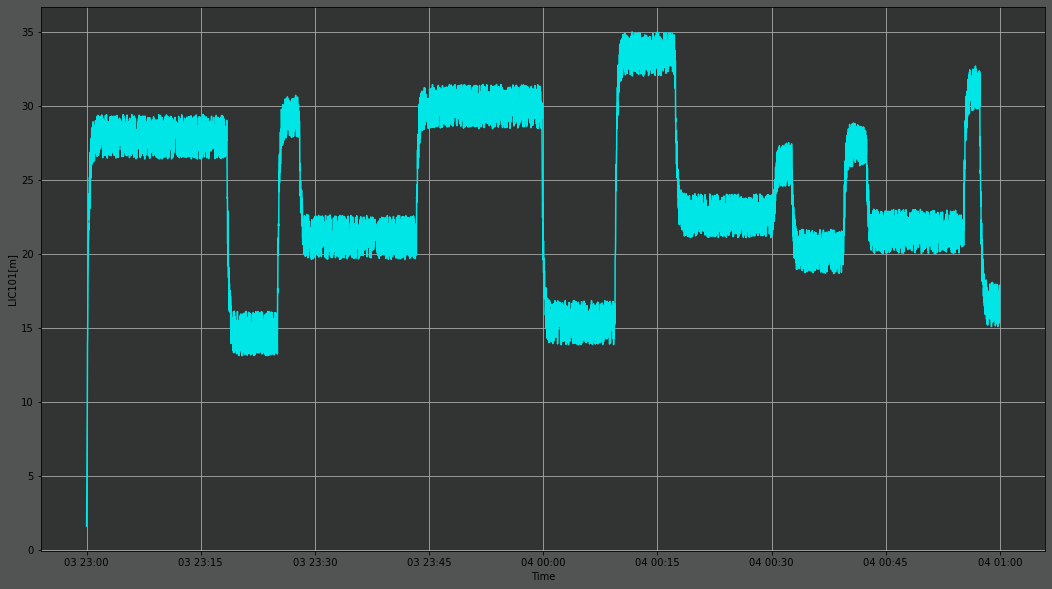

In [11]:
# Fazendo o gráfico utilizando o eixo dos tempos (abissas) com valores em data-hora local
def utc2tz(dt, tz):
    """ Converte date-time em UTC para timezone informada - removendo tzinfo
    """
    return dt.astimezone(tz).replace(tzinfo=None)

local_timestamp = list(map(utc2tz, data['Timestamp'], [tz_sp]*len(data)))
# Em versões anteriores da Matplotlib/Pandas havia um erro ao tentar usar datetime-timezone aware,
# por isso a remoção de tzinfo na função "utc2tz" definida acima.
# local_timestamp = data['Timestamp']
# Mensagem de erro que ocorria: AttributeError: 'datetime.timezone' object has no attribute '_utcoffset'
# Referências:
# https://github.com/matplotlib/matplotlib/issues/12310
# https://github.com/pandas-dev/pandas/issues/22859
# Pandas converter, use to extract date str for axis labels, fails when index is timezone aware.
# This happends only if matplotlib>=3.0.0 version is installed. I reported the bug first to
# matplotlib (matplotlib/matplotlib#12310), but the close it as they believe that the bug is in pandas
# converter.

# Criando a figura antes de fazer o plot
# matplotlib.pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.plot(local_timestamp, data['Value'], color='#00e6e6')
ax.set_xlabel("Time")
ax.set_ylabel(bv_LIC101.name + '[' + bv_LIC101.eu + ']')
ax.grid(True)
ax.set_facecolor('#323434')

#### Consulta usando Agregações (= processamento dos dados - server side)

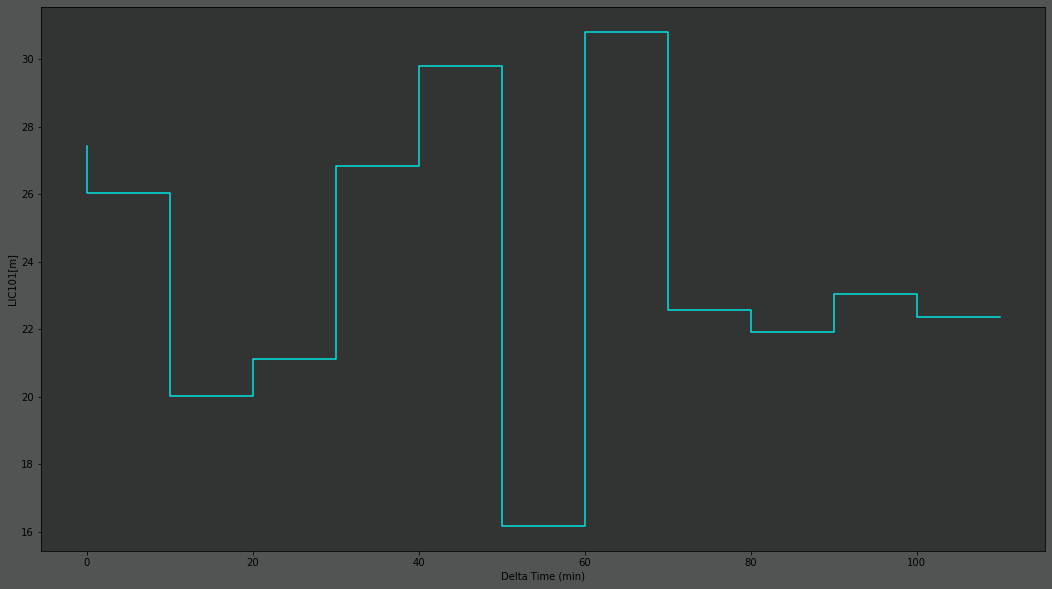

In [12]:
# Consulta usando Agregações (= processamento dos dados - server side)
# Assim como nas consultas RAW, o s valores "devem" ser informados em conformidade com o Timezone
# ou em UTC (Coordinated Universal Time) - sendo preferível sempre trabalhar em UTC!
ini_date = datetime.datetime(2014, 3, 4, 2, tzinfo=pytz.utc)
end_date = datetime.datetime(2014, 3, 4, 4, tzinfo=pytz.utc)
query_period = epm.QueryPeriod(ini_date, end_date)
process_interval = datetime.timedelta(minutes=10)
# Dica: usar TAB após "epm.AggregateType." para ver métodos disponíveis (intelisense)
aggregate_details = epm.AggregateDetails(process_interval, epm.AggregateType.TimeAverage)
# Executando a consulta agregada da Média Ponderada ao longo do tempo (a cada 10 minutos)
data = bv_LIC101.historyReadAggregate(aggregate_details, query_period)
# Mostrando em um gráfico do tipo degrau, tendo o valor anterior como referência (padrão)
t = np.arange(0, len(data))*10
plt.step(t, data['Value'], where='pre', color='#00e6e6') # where é 'pre' por padrão!
plt.xlabel("Delta Time (min)")
plt.ylabel(bv_LIC101.name + '[' + bv_LIC101.eu + ']')
# Notas extras:
# Redimensionando e colorindo a figura posteriormente á sua criação
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')
#fig.savefig(bv_LIC101.name + '.png', dpi=100) # salvar imagem em arquivo

5. **Leitura** de anotações

#### A anotação consiste de uma mensagem criada por um analista, que está associada à uma variável em um dado *Timestamp*.

* Anotação de um TAG é identificada univocamente por uma terna: TAG, *Timestamp* e Usuário
* Mais de um usuário pode criar uma anotação em um mesmo TAG em um mesmo *Timestamp*
* NENHUM usuário pode EDITAR uma anotação feita por outro!!! *(propriedade intelectual)*
* APENAS Administradore podem APAGAR anotações (de qualquer usuário)!

In [13]:
# Todas as anotações do período solicitado são retornadas em uma lista
annotations = bv_LIC101.readAnnotations(ini_date, end_date)
for annotation in annotations:
    print(f'ANOTAÇÃO: {annotation}\n')

ANOTAÇÃO: (datetime.datetime(2014, 3, 3, 23, 1, tzinfo=tzoffset(None, -10800)), 'sa', 'Início dos testes em planta!')

ANOTAÇÃO: (datetime.datetime(2014, 3, 4, 0, 59, tzinfo=tzoffset(None, -10800)), 'sa', 'Final dos testes em planta!')

ANOTAÇÃO: (datetime.datetime(2014, 3, 3, 23, 38, tzinfo=tzoffset(None, -10800)), 'mauricio', 'Início do teste - MSP!')

ANOTAÇÃO: (datetime.datetime(2014, 3, 4, 0, 15, tzinfo=tzoffset(None, -10800)), 'mauricio', 'Fim do teste - MSP!')



### Dica

###### Ver exemplo de uso de anotações no GitHub da Elipse Software: [Elipse Software/epmwebapi/exemplos/sample01.ipynb](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/blob/master/exemplos/sample01.ipynb)

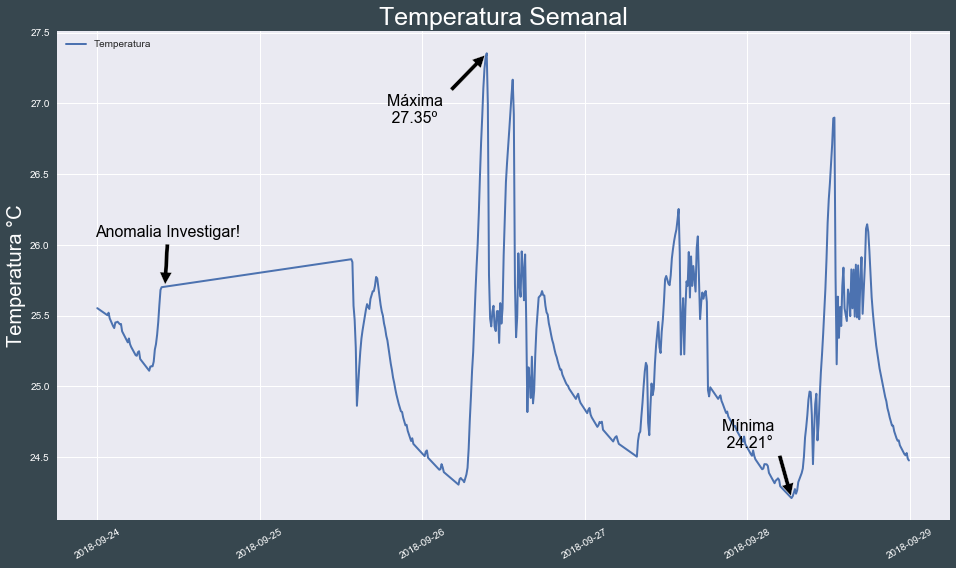

6. **Escrita** de valores escalares

#### Para escrever um valor escalar é preciso saber que:

* Só é possível escrever em Basic Variables (=*Tags*) "ATIVA" e que NÃO tenham vínculo com alguma interface de comunicação!
* As opções "Enable realtime" e "Record" da Basic Variable devem estar habilitadas
* Tem que informar: valor (condizente com a variável), *timestamp* (UTC) e qualidade (OPC UA)
* O *timestamp* anterior ao último valor-timestamp-qualidade armazenado vai para o processamento de valores *Out of Order* - mais custoso!
* O *timestamp* coincidente com o *timestamp* de outro valor-timestamp-qualidade previamente armazenado, promove a substição pelo mais novo!
* É preciso que a sessão de comunicação com o EPM Server tenha sido feita com um usuário com permissões de escrita!

#### Eu poderia simplesmente "mandar escrever" um valor:

* aleatório (random);
* lido de um instrumento de campo via: Modbus, MQTT (paho), AMQP (pika), OPC UA (Free OPC UA), ...;
* lido de um arquivo: .CSV, .XLSX, .HDF5, ....;
* lido de um banco de dados SQL(RDB's - PostgreSQL, MySQL, MS SQL Server, ...) | NoSQL (MongoDB, etc.) | ...;
* proveniente de uma simulação em tempo real (ex.: [www.ufrgs.br/reamat/CalculoNumerico/livro-py/pdvi-metodo_de_euler](https://www.ufrgs.br/reamat/CalculoNumerico/livro-py/pdvi-metodo_de_euler.html));

*da ref. acima: Em Python, podemos computar a solução numérica deste problema de valor inicial via o método de Euler com o seguite código*
``` python
#define f(t,u)  
def f(t,u):  
    return 2*u  
#tamanho e num. de passos  
h = 0.2  
N = 6  
#cria vetor t e u  
t = np.empty(N)  
u = np.copy(t)  
#C.I.  
t[0] = 0  
u[0] = 1  
#iteracoes  
for i in np.arange(N-1):  
    t[i+1] = t[i] + h  
    u[i+1] = u[i] + h*f(t[i],u[i])  
#imprime  
for i,tt in enumerate(t):  
    print("%1.1f %1.4f" % (t[i],u[i]))
```

In [14]:
# Ou usa a função ODEINT do módulo Scipy.Integrate  :)
from scipy.integrate import odeint
# Modelo do processo
def process_model(y, t, k, u):
    tau  = 0.5 # constante de tempo
    dydt = (k * u - y)/tau # Equação diferencial ordinária (EDO)
    return dydt

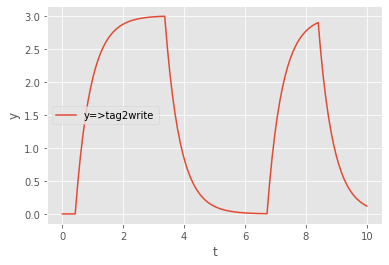

In [15]:
# Verificando o resultado da simulação antes de escrever em uma variável no EPM Server, em "tempo real".
k = 3.0 # ganho
n = 120 # número de pontos - 2 minutos -> 1 por segundo
t = np.linspace(0, 10, n)
u = np.zeros(n)
u[5:40] = 1.0 # degraus na entrada
u[80:100] = 1.0 # degraus na entrada
yf = np.zeros(n, dtype=float) # vetor com zeros do tipo float
# Integrando
for i in range(n-1):
    ts = [t[i], t[i+1]]
    y = odeint(process_model, yf[i], ts, args=(k, u[i]))
    yf[i+1] = y[1]

# "Plota" o resultado
plt.style.use('ggplot')
plt.plot(t, yf)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y=>tag2write'], loc='best')

In [16]:
# Simulando em tempo real e escrevendo em uma variável do EPM (tag2write)
# Dicas:
#  * Organizar o código em FUNÇÕES - modularizar!
#  * Acompanhar escrita em tempo real no Chart Analysis do EPM Studio! :)
import time
#tz = datetime.timezone(datetime.timedelta(hours=-3)) # Se preferir usar hora local
tag2write = epmConn.getDataObjects(['tag2write'])['tag2write']
update_time = 1 # informar em segundos
quality = 0 # 0 corresponde à "Good" no Padrão OPC UA
wresult = []
yf = np.zeros(n, dtype=float) # vetor com zeros do tipo float
try:
    wresult.append(tag2write.write(yf[0], datetime.datetime.now(datetime.timezone.utc), quality ))
    time.sleep(update_time)
except Exception as error:
    wresult.append(error)
# Integrando
for i in range(n-1):
    ts = [t[i], t[i+1]]
    y = odeint(process_model, yf[i], ts, args=(k, u[i]))
    yf[i+1] = y[1]
    try:
        wresult.append(tag2write.write(yf[i+1], datetime.datetime.now(datetime.timezone.utc), quality ))
        time.sleep(update_time)
    except Exception as error:
        wresult.append(error)
print('Fim da simulação em tempo real!!!')

Fim da simulação em tempo real!!!


#### Recomendo "aprender" a usar a [GEKKO](https://gekko.readthedocs.io/en/latest/)

* GEKKO is a Python package for machine learning and optimization of mixed-integer and differential algebraic equations.
* It is coupled with large-scale solvers for linear, quadratic, nonlinear, and mixed integer programming (LP, QP, NLP, MILP, MINLP).
* Modes of operation include parameter regression, data reconciliation, real-time optimization, dynamic simulation, and nonlinear predictive control.

##### GEKKO is an object-oriented Python library to facilitate local execution of APMonitor.

* [Exemplos no Jupyter Notebook](https://nbviewer.jupyter.org/url/apmonitor.com/wiki/uploads/Main/gekko.ipynb)
* [GEKKO Optimization Suite Overview](https://youtu.be/dEW9yrJyg24)

7. **Escrita** de valores históricos

#### Para escrever "dados históricos" é preciso saber que:

* Só é possível escrever em Basic Variables (=*Tags*) "ATIVAS" e que NÃO tenham vínculo com alguma interface de comunicação!
* A opção "Record" da Basic Variable deve estar habilitada
* Tem que informar: valor (condizente com a variável), *timestamp* (UTC) e qualidade (OPC UA)
* Os dados precisam estar no formato NUMPY ARRAY - 'Value' | 'Timestamp' | 'Quality'
* Os *timestamps* coincidentes com *timestamps* de outros valores previamente armazenados, promove a substição pelos mais novos!
* É preciso que a sessão de comunicação com o EPM Server tenha sido feita com um usuário com permissões de escrita!

ref. [gekko](https://nbviewer.jupyter.org/url/apmonitor.com/wiki/uploads/Main/gekko.ipynb)

**PID Control Tuning**
A PID Controller has proportional, integral, and derivative terms to determine the controller output ($OP$) based on the set point ($SP$) and process variable ($PV$).

A standard PID form has constants $K_c$, $τ_I$, and $τ_D$.

$err = SP−PV$

$OP = OP_0 + K_c \, err + \frac{K_c}{\tau_I} \int err \, dt - K_c \, \tau_D \frac{d\,PV}{dt}$

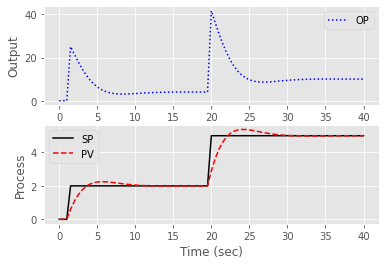

In [17]:
# Simulação usando a GEKKO para gerar dados para escrita nas variáveis: gekko_PV, gekko_OP e gekko_SP
from gekko import GEKKO

m = GEKKO()
tf = 40
m.time = np.linspace(0, tf, 2*tf+1)
step = np.zeros(2*tf+1)
step[3:40] = 2.0
step[40:]  = 5.0

# Controller model
Kc = 15.0                   # controller gain
tauI = 2.0                  # controller reset time
tauD = 1.0                  # derivative constant
OP_0 = m.Const(value=0.0)   # OP bias
OP = m.Var(value=0.0)       # controller output
PV = m.Var(value=0.0)       # process variable
SP = m.Param(value=step)    # set point
Intgl = m.Var(value=0.0)    # integral of the error
err = m.Intermediate(SP-PV) # set point error
m.Equation(Intgl.dt()==err) # integral of the error
m.Equation(OP == OP_0 + Kc*err + (Kc/tauI)*Intgl - PV.dt())

# Process model
Kp = 0.5                    # process gain
tauP = 10.0                 # process time constant
m.Equation(tauP*PV.dt() + PV == Kp*OP)

m.options.IMODE=4
m.solve(disp=False)

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,OP.value,'b:',label='OP')
plt.ylabel('Output')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m.time,SP.value,'k-',label='SP')
plt.plot(m.time,PV.value,'r--',label='PV')
plt.xlabel('Time (sec)')
plt.ylabel('Process')
plt.legend()

In [18]:
# Escrevendo valores históricos no EPM Server
gekko_PV = epmConn.getDataObjects(['gekko_PV'])['gekko_PV']
gekko_SP = epmConn.getDataObjects(['gekko_SP'])['gekko_SP']
gekko_OP = epmConn.getDataObjects(['gekko_OP'])['gekko_OP']

ini_date  = datetime.datetime(2019, 8, 2, 12, tzinfo=pytz.utc) # Em Brasília - 9:00 !!!
timestamp = np.array([ini_date + datetime.timedelta(seconds=(dt*10)) for dt in m.time])
# EPM ndarray data format
desc = np.dtype([('Value', '>f8'), ('Timestamp', 'object'), ('Quality', '>i4')])
# Inicializando a matriz (numpy array) com os Valores|Timestamps|Qualidades
n = len(timestamp)
pv = np.zeros(n, dtype=desc) # "Good" do OPC UA -> coluna Quality já fica com qualidade boa
sp = np.zeros(n, dtype=desc) # "Good" do OPC UA -> coluna Quality já fica com qualidade boa
op = np.zeros(n, dtype=desc) # "Good" do OPC UA -> coluna Quality já fica com qualidade boa
# Montando a estrutura de dados 
pv['Value'] = np.array(PV.value) # type(PV.value) -> gekko.gk_operators.GK_Value
pv['Timestamp'] = timestamp
sp['Value'] = np.array(SP.value) # type(SP.value) -> gekko.gk_operators.GK_Value
sp['Timestamp'] = timestamp
op['Value'] = np.array(OP.value) # type(OP.value) -> gekko.gk_operators.GK_Value
op['Timestamp'] = timestamp
# Escrevendo no EPM Server
gekko_PV.historyUpdate(pv)
gekko_SP.historyUpdate(sp)
gekko_OP.historyUpdate(op)
print("Dados da simulação com o controlador PID foram escritos no EPM Server!!!")

Dados da simulação com o controlador PID foram escritos no EPM Server!!!


8. **Escrita** de anotações

#### Para escrever uma anotação é preciso saber que:

* Só é possível escrever anotações em Basic Variables (=Tags) "ATIVAS"
* Tem que informar: mensagem (*string*), timestamp (UTC), enquanto que o usuário da sessão é automaticamente utilizado para compor a chave de identificação única da anotação no *Tag*;
* Um eventual *timestamp* coincidente com o *timestamp* de outra anotação de um MESMO usuário, promove a substição pela mais nova!
* É preciso que a sessão de comunicação com o EPM Server tenha sido feita com um usuário com permissões de escrita!

In [22]:
# Escrevendo anotação
message = 'Valor mínimo encontrado no periodo.'
timestamp = datetime.datetime(2019, 8, 5, 17, 13, 1, tzinfo=pytz.utc)
tag2write.writeAnnotation(timestamp,message)
print("Anotação escrita na variável: tag2write")

Anotação escrita na variável: tag2write


9. **CRUD** (Create, Read, Update and Delete) de variáveis - não faz parte do escopo deste minicurso

#### Para operações de CRUD é preciso saber que:

* O usuário deve ter as devidas permissões;
* As operações ficam registradas em um arquivo de log;
* RECOMENDA-SE MUITO CUIDADO COM ESTA FUNCIONALIDADE - *"Grandes poderes trazem grandes responsabilidades..."*

10. **Encerramento da Conexão** (=sessão) com um **EPM Server** (=servidor de dados)

#### É ALTAMENTE RECOMENDADO SEMPRE encerrar a sessão previamente criada !!!

* Ao encerrar a sessão, a conexão de *EPM Client* que estava sendo contabilizada na *Hard Key (HK)* é liberada para que outro usuário possa fazer uso dela;
* A sessão tem um *Time out* de 5 minutos - se o processo Python "cair", a sessão será liberada automaticamente após transcorrido este tempo;

In [23]:
# SEMPRE deve-se encerrar a conexão estabelecida com o EPM Server, pois isso irá encerrar a sessão e
# liberar a licença de EPM Client para que outros, eventualmente, possam utilizá-la.
epmConn.close()

#### DICAS

[Exemplos no GitHub da Elipse Software](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/tree/master/exemplos/)

[EPM para analistas de dados: análises preliminares utilizando o módulo pandas da linguagem Python](https://youtu.be/DPrZv80fOuw)

[Webinar - Agilizando análises no EPM com o poder da linguagem Python](https://youtu.be/1u9z6YD_2P0)

[Webinar - Análise de Dados com Python e Dashboard Web](https://youtu.be/IYg5yutkIhw)

[Exemplos MSP no Anaconda Cloud](https://anaconda.org/mauricioposser)

## _FIM dos exemplos ..._

#### Retornar à apresentação